##  Coarsage for Probabilistic Regression - Some Extra Details
## (Conditional Density Estimation)


Here we will go through a couple of additional examples to demonstrate some other parameters of Coarsage and when they are applicable.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import structureboost as stb
import ml_insights as mli
from sklearn.model_selection import train_test_split



## Baseball Runs Scored
Here we load in a data set of MLB games.  Each row gives some statistics of the hitting team, the opposing pitchers, and the number of runs that were scored.  We will demonstrate how to predict the distribution of the number of runs scored.

In [2]:
df_runs = pd.read_csv('bball_runs_sm.csv')

In [3]:
print(df_runs.shape)

(24284, 13)


In [4]:
df_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24284 entries, 0 to 24283
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            24284 non-null  int64  
 1   date_dblhead     24284 non-null  int64  
 2   team_h           24284 non-null  object 
 3   team_v           24284 non-null  object 
 4   home_hitting     24284 non-null  int64  
 5   runs             24284 non-null  int64  
 6   OBP_162          24284 non-null  float64
 7   SLG_162          24284 non-null  float64
 8   Strt_WHIP_35     24284 non-null  float64
 9   Strt_SO_perc_10  24284 non-null  float64
 10  Bpen_WHIP_75     24284 non-null  float64
 11  Bpen_SO_perc_75  24284 non-null  float64
 12  Bpen_WHIP_35     24284 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 2.4+ MB


In [5]:
df_runs.sample(5, random_state=0)

,index,date_dblhead,team_h,team_v,home_hitting,runs,OBP_162,SLG_162,Strt_WHIP_35,Strt_SO_perc_10,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_WHIP_35
2894,2894,201605090,BOS,OAK,1,14,0.327880,0.430111,1.171053,0.195219,1.256228,0.204282,1.079019
13085,13085,201506150,ANA,ARI,0,7,0.304823,0.373391,1.246575,0.115942,1.263393,0.230519,1.217712
15829,15829,201607050,WAS,MIL,0,5,0.318220,0.394835,1.387755,0.272727,1.143307,0.272727,1.261589
3662,3662,201607040,MIN,OAK,1,1,0.306786,0.406504,1.450607,0.128205,1.349045,0.230129,1.385224
16642,16642,201609070,NYA,TOR,0,0,0.329603,0.443924,1.547619,0.175000,1.185286,0.276382,1.313559


In [6]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)
df_runs['season']=df_runs.date_dblhead.apply(lambda x: int(str(x)[:4]))

In [7]:
df_runs.season.value_counts()

2017    4860
2015    4858
2019    4858
2016    4854
2018    4854
Name: season, dtype: int64

In [8]:
df_train = df_runs[df_runs.season<=2017]
df_valid = df_runs[df_runs.season==2018]
df_test = df_runs[df_runs.season>=2019]

## Begin Modeling

In [9]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35']
target = 'runs'

In [10]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

For this problem, we know the "bins" we want.  So we can choose `binpt_method='fixed'` and specify the bins we want.

When dealing with integer valued target variables, it is useful to have bins of width 1, so that the density = the probability.  It is also nice for plotting to have the bins centered at the integer values

In [11]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

This gives us 17 bins, representing 0, 1, 2, ..., 16+ runs scored for that team

In [12]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4490039762731746
i=10, eval_set_loss = 2.4461476346461826
i=20, eval_set_loss = 2.4441703123877976
i=30, eval_set_loss = 2.442561412003207
i=40, eval_set_loss = 2.4413205295364366
i=50, eval_set_loss = 2.440680353700598
i=60, eval_set_loss = 2.4404502068717147
i=70, eval_set_loss = 2.440223817837822
i=80, eval_set_loss = 2.4404008323653885
i=90, eval_set_loss = 2.440507078575545
i=100, eval_set_loss = 2.4407266462121475
i=110, eval_set_loss = 2.440598732908706
i=120, eval_set_loss = 2.440846893448357
Stopping early: low pt was 5 steps ago


In [13]:
preds_test = cr1.predict_distributions(X_test)

In [14]:
preds_test.log_loss(y_test)

2.50026321021628

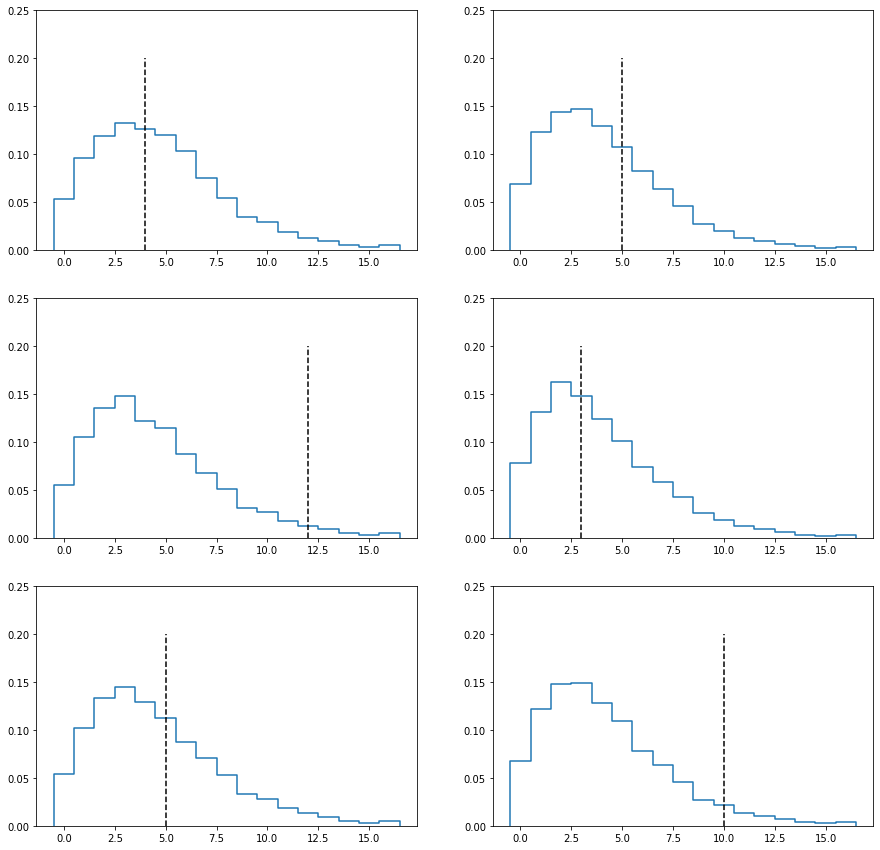

In [15]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

When using `binpt_method = 'fixed'` it will always use the exact subdivision it is given.  For a small number of bins, this generally makes sense.  However, if you had a larger number of bins (say 200), you might want to subdivide within the set of given binpts.  To do this, you must choose `binpt_method = 'fixed-rss'` and specify `num_coarse_bins`.

In [16]:
cr2 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed-rss', num_coarse_bins=10,
               binpt_vec=bpv2)
cr2.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4616511642661565
i=10, eval_set_loss = 2.4563508708022597
i=20, eval_set_loss = 2.4521156392641985
i=30, eval_set_loss = 2.449566749882437
i=40, eval_set_loss = 2.4474150789640037
i=50, eval_set_loss = 2.4462788053246736
i=60, eval_set_loss = 2.4455477953243627
i=70, eval_set_loss = 2.4447636571056357
i=80, eval_set_loss = 2.444554465637454
i=90, eval_set_loss = 2.4442736652122607
i=100, eval_set_loss = 2.4434168012405397
i=110, eval_set_loss = 2.4433219581624117
i=120, eval_set_loss = 2.4432129083927796
i=130, eval_set_loss = 2.4431541742677365
i=140, eval_set_loss = 2.443496927882747
i=150, eval_set_loss = 2.4440558389050593
i=160, eval_set_loss = 2.4440731343740403
i=170, eval_set_loss = 2.4446327828509324
i=180, eval_set_loss = 2.445040860344541
Stopping early: low pt was 5 steps ago


In [17]:
preds_test = cr2.predict_distributions(X_test)

In [18]:
preds_test.log_loss(y_test)

2.5029181522181663

It is *not* recommended to use `binpt_method='auto'` (the default) when you have integer-valued data (for a variety of reasons).  In some situations it may actually give better log-loss values, but it is effectively "cheating" (you can make log-loss as small as you want by making narrower intervals around the integer values)

In [19]:
Let's look at some of the other parameters in Coarsage:

SyntaxError: EOL while scanning string literal (2834320074.py, line 1)

In [ ]:
stb.Coarsage?

Next, let's revisit the Ames housing data

In [ ]:
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)
df_house.info()

In [ ]:
#df_house.columns = [x.replace(' ','_') for x in df_house.columns]

In [ ]:
df_house.sample(5)

In [ ]:
feat = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces']

In [ ]:
X = df_house.loc[:,feat]  # everything except Sale Price
y = df_house.SalePrice.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [ ]:
cr3 = stb.Coarsage(num_trees=2000, learning_rate=.05, max_depth=8, num_coarse_bins=30)
cr3.fit(X_train, y_train, eval_set=(X_test, y_test), early_stop_past_steps = 5)

In [ ]:
cr3_preds = cr3.predict_distributions(X_test)
cr3_preds.log_loss(y_test)

In [ ]:
i=0
cr3_preds[i].plot_density()
plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')

In [ ]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    cr3_preds[i].plot_density()
    plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')